In [3]:
import pandas as pd

# Użyj surowego stringa (r przed ścieżką) lub zamień \ na /
df = pd.read_csv(r"C:\Users\Weron\ML\archive\AB_NYC_2019.csv")  

# Podgląd pierwszych wierszy
print(df.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

In [4]:
# Podstawowe informacje o danych
print(df.info())

# Statystyki opisowe dla kolumn numerycznych
print(df.describe())

# Sprawdzenie brakujących wartości
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
# Usuń rekordy z ceną = 0
df = df[df['price'] > 0]

# Usuwanie zbędnych kolumn (które nie będą użyteczne w modelu)
df_clean = df.drop(columns=['id', 'host_name', 'last_review'])

# Uzupełnienie brakujących wartości w 'reviews_per_month' (np. medianą)
df_clean['reviews_per_month'].fillna(df_clean['reviews_per_month'].median(), inplace=True)

# Usuwanie rekordów z brakującymi danymi (jeśli potrzeba)
df_clean.dropna(subset=['name'], inplace=True)  # przykładowo dla kolumny 'name'

# Filtrowanie outlierów w cenie (np. ceny między 10 a 1000 dolarów)
df_clean = df_clean[(df_clean['price'] >= 10) & (df_clean['price'] <= 1000)]

C:\Users\Weron\AppData\Local\Temp\ipykernel_21064\3379770517.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['reviews_per_month'].fillna(df_clean['reviews_per_month'].median(), inplace=True)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


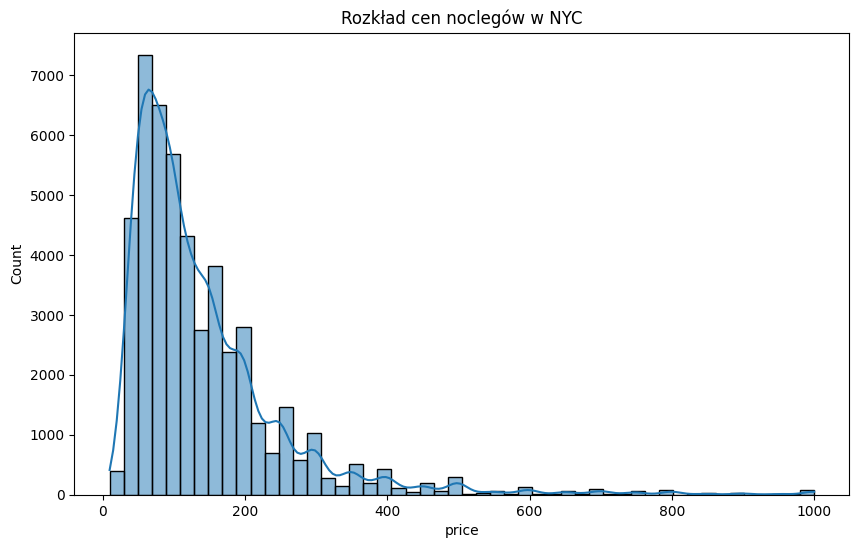

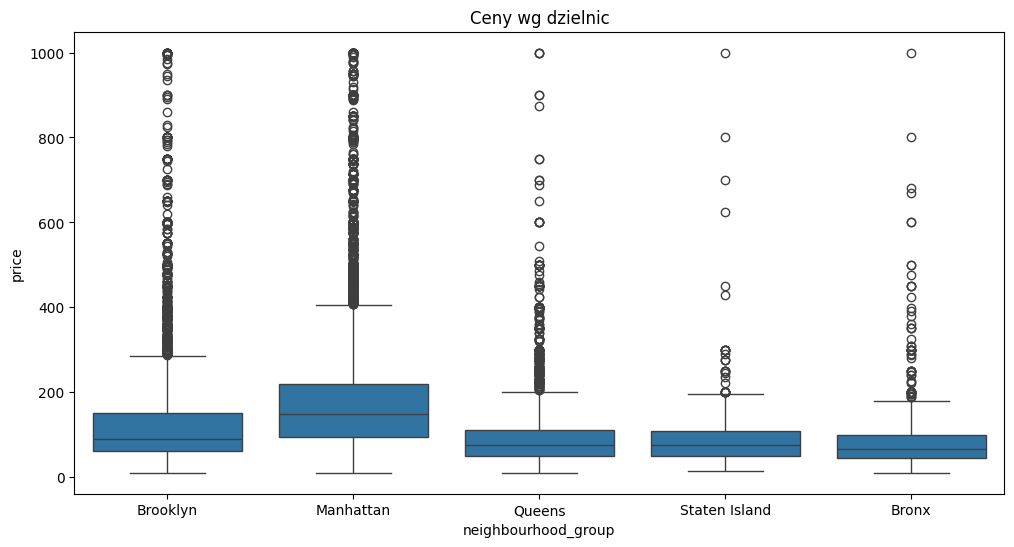

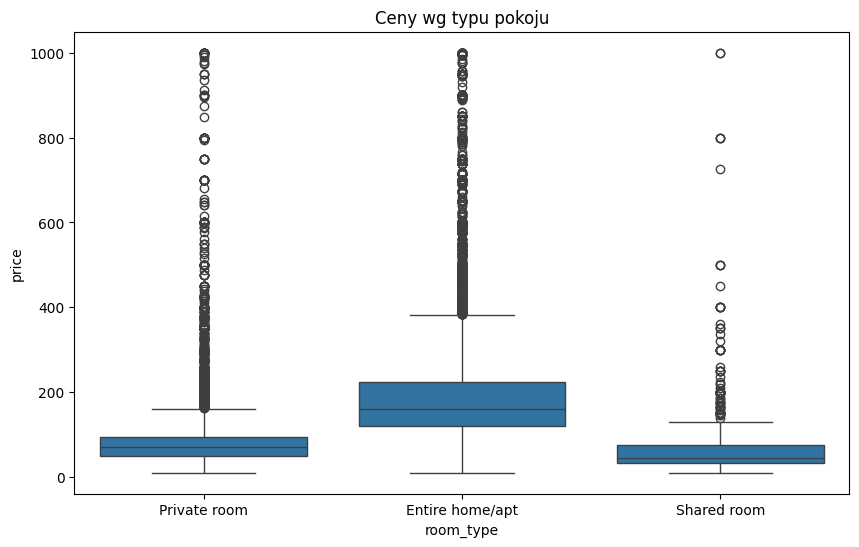

In [7]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Rozkład cen
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Rozkład cen noclegów w NYC')
plt.show()

# Ceny wg dzielnic
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='neighbourhood_group', y='price')
plt.title('Ceny wg dzielnic')
plt.show()

# Zależność ceny od typu pokoju
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='room_type', y='price')
plt.title('Ceny wg typu pokoju')
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

# Kodowanie zmiennych kategorycznych
le = LabelEncoder()
df_clean['neighbourhood_group_encoded'] = le.fit_transform(df_clean['neighbourhood_group'])
df_clean['room_type_encoded'] = le.fit_transform(df_clean['room_type'])

# One-Hot Encoding dla kolumn kategorycznych (opcjonalnie)
# df_clean = pd.get_dummies(df_clean, columns=['neighbourhood_group', 'room_type'])

# Wybór cech (X) i zmiennej docelowej (y)
X = df_clean[['neighbourhood_group_encoded', 'room_type_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
y = df_clean['price']

# Podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("Sprawdzam brakujące wartości:")
print(X_train.isnull().sum())
print(y_train.isnull().sum())

Sprawdzam brakujące wartości:
neighbourhood_group_encoded    0
room_type_encoded              0
minimum_nights                 0
number_of_reviews              0
reviews_per_month              0
dtype: int64
0


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Wersja bezpieczna dla wszystkich wersji scikit-learn
def calculate_rmse(y_true, y_pred):
    try:
        # Dla scikit-learn >= 1.4
        return mean_squared_error(y_true, y_pred, root=True)
    except TypeError:
        # Dla starszych wersji
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Trenowanie modelu z optymalnymi parametrami
model = RandomForestRegressor(
    n_estimators=150,        # Zwiększona liczba drzew
    max_depth=15,            # Ograniczenie głębokości
    min_samples_split=5,     # Minimalna liczba próbek do podziału
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich procesorów
)

model.fit(X_train, y_train)

# Predykcja i ewaluacja
y_pred = model.predict(X_test)

rmse = calculate_rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Procentowy błąd

# Prezentacja wyników
print("\n" + "="*50)
print(f"RMSE: {rmse:.2f} USD")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print("="*50)

# Ważność cech
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
print("\nNajważniejsze cechy:")
print(feature_importance.sort_values(ascending=False).head(10))


RMSE: 99.20 USD
R²: 0.2967
MAPE: 45.38%

Najważniejsze cechy:
room_type_encoded              0.453814
reviews_per_month              0.213619
number_of_reviews              0.126387
neighbourhood_group_encoded    0.105608
minimum_nights                 0.100572
dtype: float64
